In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from typing import List
import time
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

sys.path.append("../")

from RGS import *
from data_generator import *
# from data_plotting import *
from data_plotting_test import *
from IPython.display import display, HTML, clear_output
from time import sleep

In [ ]:
def calculate_df(y, y_true, y_pred, n, sigma):
    """Calculate degrees of freedom using the provided formula."""
    train_error = np.mean((y - y_pred)**2)
    insample_error = np.mean((y_true - y_pred)**2)
    df = n/(2*sigma**2) * (insample_error - train_error + sigma**2)
    return df

In [ ]:
def compute_penalized_score(model, X, y_true, k, sigma2, n, p):
    """
    Compute penalized score using MSE + penalty.
    
    Parameters
    ----------
    model : RGS/GS model
        Fitted model with .coef_ attribute
    X : ndarray
        Input design matrix
    y_true : ndarray
        True signal (without noise)
    k : int
        Number of features to use
    sigma2 : float
        True noise variance
    n : int
        Sample size
    p : int
        Number of features
        
    Returns
    -------
    float
        Penalized score (MSE + penalty)
    """
    # Get predictions and MSE
    y_pred = model.predict(X, k=k)
    mse = mean_squared_error(y_true, y_pred)
    
    # Compute penalty
    penalty = 2*sigma2**2/n*k*np.log(p/k)
    
    return mse + penalty

In [ ]:
class ProgressDisplay:
    def __init__(self, total, desc="Progress"):
        self.total = total
        self.desc = desc
        self.current = 0
        self.start_time = time.time()
        
    def update(self, n=1):
        self.current += n
        self._display_progress()
        
    def _display_progress(self):
        clear_output(wait=True)
        percentage = (self.current / self.total) * 100
        elapsed_time = time.time() - self.start_time
        rate = self.current / elapsed_time if elapsed_time > 0 else 0
        eta = (self.total - self.current) / rate if rate > 0 else 0
        
        progress_bar = f"[{'=' * int(percentage/2)}{' ' * (50-int(percentage/2))}]"
        print(f"{self.desc}: {progress_bar} {percentage:.1f}%")
        print(f"Progress: {self.current}/{self.total}")
        print(f"Elapsed: {elapsed_time:.1f}s, ETA: {eta:.1f}s, Rate: {rate:.1f} it/s")

def run_simulation(n_predictors=500, n_train=2000, signal_proportion=0.02, 
                           cov='banded', n_sim=10):
    """Run simulation finding optimal (m,k) pairs without recomputing."""
    start_time = time.time()
    
    # Generate base design matrix
    X_generators = {
        'orthogonal': generate_orthogonal_X,
        'banded': generate_banded_X
    }
    X_generator = X_generators[cov] if isinstance(cov, str) else cov
    X = X_generator(n_predictors, n_train)
    
    # Define k values for training and m values for RGS
    k_values = [1, 4, 7, 10, 15, 20, 25] 
    base = 2
    num_points = 7
    m_values = [int(2 + (n_predictors-2) * (base**x - 1)/(base**(num_points-1) - 1)) 
                for x in range(num_points)]
    k_max = 35  # Maximum k value we're interested in
    
    # Initialize results storage
    results = []
    
    # Define example generators with different noise levels
    sigma_dict = {
        'orthogonal': [10, 15, 20, 30, 40],
        'banded': [1, 3, 5, 10, 15]
    }
    sigmas = sigma_dict[cov]
    example_generators = {f'sigma_{sigma}': generate_exact_sparsity_example 
                        for sigma in sigmas}
    
    # Initialize progress display
    total_iterations = n_sim * len(example_generators)
    progress = ProgressDisplay(total_iterations, desc="Simulation Progress")
    
    for sim in range(n_sim):
        for i, (noise_level, generator) in enumerate(example_generators.items()):
            # Generate data
            X, y, y_true, beta_true, p, sigma = generator(X, signal_proportion, 
                                                        sigmas[i], seed=sim)
            
            # Fit baseline models
            # Lasso
            lasso = LassoCV(cv=10, random_state=sim)
            lasso.fit(X, y)
            y_pred_lasso = lasso.predict(X)
            
            # Ridge
            ridge = RidgeCV(cv=10)
            ridge.fit(X, y)
            y_pred_ridge = ridge.predict(X)
            
            # Elastic Net
            elastic = ElasticNetCV(cv=10, random_state=sim)
            elastic.fit(X, y)
            y_pred_elastic = elastic.predict(X)
            
            # Store base results with all metrics
            base_result = {
                'simulation': sim,
                'noise_level': noise_level,
                'sigma': sigma,
                # Lasso metrics
                'mse_lasso': mean_squared_error(y_true, y_pred_lasso),
                'df_lasso': calculate_df(y, y_true, y_pred_lasso, n_train, sigma),
                'coef_recovery_lasso': np.mean((lasso.coef_ - beta_true)**2),
                'support_recovery_lasso': np.mean((lasso.coef_ != 0) == (beta_true != 0)),
                # Ridge metrics
                'mse_ridge': mean_squared_error(y_true, y_pred_ridge),
                'df_ridge': calculate_df(y, y_true, y_pred_ridge, n_train, sigma),
                'coef_recovery_ridge': np.mean((ridge.coef_ - beta_true)**2),
                # Elastic Net metrics
                'mse_elastic': mean_squared_error(y_true, y_pred_elastic),
                'df_elastic': calculate_df(y, y_true, y_pred_elastic, n_train, sigma),
                'coef_recovery_elastic': np.mean((elastic.coef_ - beta_true)**2),
                'support_recovery_elastic': np.mean((elastic.coef_ != 0) == (beta_true != 0))
            }
            
            # Fit GS for each k value
            gs = RGS(k_max=k_max, m=n_predictors, n_resample_iter=7)
            gs.fit(X, y)
            for k in k_values:
                y_pred_gs = gs.predict(X, k=k)
                base_result.update({
                    f'mse_gs_k{k}': mean_squared_error(y_true, y_pred_gs),
                    f'df_gs_k{k}': calculate_df(y, y_true, y_pred_gs, n_train, sigma),
                    f'pen_gs_k{k}': compute_penalized_score(gs, X, y_true, k, sigma, n_train, p),
                    f'coef_recovery_gs_k{k}': np.mean((gs.coef_[k] - beta_true)**2),
                    f'support_recovery_gs_k{k}': np.mean((np.abs(gs.coef_[k]) > 1e-10) == (beta_true != 0))
                })
            
            # Fit RGS for each m,k value
            for m in m_values:
                # Train RGS once with maximum k
                rgs = RGS(k_max=k_max, m=m, n_resample_iter=7)
                rgs.fit(X, y)
                
                for k in k_values:
                    y_pred = rgs.predict(X, k=k)
                    
                    # Create new result with all baseline metrics
                    result = base_result.copy()
                    result.update({
                        'm': m,
                        'k': k,
                        f'mse_rgs_m{m}_k{k}': mean_squared_error(y_true, y_pred),
                        f'df_rgs_m{m}_k{k}': calculate_df(y, y_true, y_pred, n_train, sigma),
                        f'pen_rgs_m{m}_k{k}': compute_penalized_score(rgs, X, y_true, k, sigma, n_train, p),
                        f'coef_recovery_rgs_m{m}_k{k}': np.mean((rgs.coef_[k] - beta_true)**2),
                        f'support_recovery_rgs_m{m}_k{k}': np.mean((np.abs(rgs.coef_[k]) > 1e-10) == (beta_true != 0))
                    })
                    results.append(result)
                
            # Update progress
            progress.update(1)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate summary statistics
    summary_metrics = {
        # Baseline metrics
        'mse_lasso': ['mean', 'std'],
        'df_lasso': ['mean', 'std'],
        'coef_recovery_lasso': ['mean', 'std'],
        'support_recovery_lasso': ['mean', 'std'],
        'mse_ridge': ['mean', 'std'],
        'df_ridge': ['mean', 'std'],
        'coef_recovery_ridge': ['mean', 'std'],
        'mse_elastic': ['mean', 'std'],
        'df_elastic': ['mean', 'std'],
        'coef_recovery_elastic': ['mean', 'std'],
        'support_recovery_elastic': ['mean', 'std']
    }
    
    # Add GS metrics for each k
    for k in k_values:
        metrics = ['mse', 'df', 'pen', 'coef_recovery', 'support_recovery']
        for metric in metrics:
            summary_metrics[f'{metric}_gs_k{k}'] = ['mean', 'std']
    
    # Add RGS metrics for each (m,k) combination
    for m in m_values:
        for k in k_values:
            metrics = ['mse', 'df', 'pen', 'coef_recovery', 'support_recovery']
            for metric in metrics:
                summary_metrics[f'{metric}_rgs_m{m}_k{k}'] = ['mean', 'std']
    
    summary = results_df.groupby('noise_level').agg(summary_metrics).round(4)
    
    # Save results
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(f'../data/simulation_results_{timestamp}.csv', index=False)
    summary.to_csv(f'../data/simulation_summary_{timestamp}.csv')
    
    print(f"\nSimulation completed in {(time.time() - start_time)/60:.1f} minutes")
    
    return results_df, summary

def plot_optimal_mk(optimal_params_df):
    """Plot optimal k values for each m and noise level."""
    plt.figure(figsize=(12, 6))
    
    for noise_level in optimal_params_df['noise_level'].unique():
        data = optimal_params_df[optimal_params_df['noise_level'] == noise_level]
        mean_k = data.groupby('m')['optimal_k'].mean()
        std_k = data.groupby('m')['optimal_k'].std()
        
        plt.errorbar(mean_k.index, mean_k.values, yerr=std_k.values, 
                    label=noise_level, marker='o')
    
    plt.xlabel('m (number of candidates)')
    plt.ylabel('Optimal k')
    plt.title('Optimal k vs m for Different Noise Levels')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    return plt.gcf()

In [ ]:
def analyze_optimal_parameters(results_df):
    """
    Analyze the results to find optimal k and m values for each noise level.
    Also includes degrees of freedom analysis.
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from run_simulation
        
    Returns:
    --------
    DataFrame with optimal parameters and corresponding MSE and DF values
    """
    noise_levels = sorted(results_df['noise_level'].unique())
    optimal_params = []
    
    for noise in noise_levels:
        noise_data = results_df[results_df['noise_level'] == noise]
        
        # Find best GS k value based on penalized
        gs_mse_cols = [col for col in noise_data.columns if col.startswith('pen_gs_k')]
        best_gs_col = min(gs_mse_cols, key=lambda x: noise_data[x].mean())
        best_gs_k = int(best_gs_col.replace('pen_gs_k', ''))
        best_gs_mse = noise_data[f'mse_gs_k{best_gs_k}'].mean()
        best_gs_df = noise_data[f'df_gs_k{best_gs_k}'].mean()
        
        # Find best RGS m and k values based on penalized
        rgs_mse_cols = [col for col in noise_data.columns if col.startswith('pen_rgs_m')]
        best_rgs_col = min(rgs_mse_cols, key=lambda x: noise_data[x].mean())
        # Extract m and k values using string replacement
        col_parts = best_rgs_col.replace('pen_rgs_m', '').split('_k')
        m_val = int(col_parts[0])
        k_val = int(col_parts[1])
        best_rgs_mse = noise_data[f'mse_rgs_m{m_val}_k{k_val}'].mean()
        best_rgs_df = noise_data[f'df_rgs_m{m_val}_k{k_val}'].mean()
        
        # Get baseline methods performance
        baseline_metrics = {
            'lasso_mse': noise_data['mse_lasso'].mean(),
            'lasso_df': noise_data['df_lasso'].mean(),
            'ridge_mse': noise_data['mse_ridge'].mean(),
            'ridge_df': noise_data['df_ridge'].mean(),
            'elastic_mse': noise_data['mse_elastic'].mean(),
            'elastic_df': noise_data['df_elastic'].mean()
        }
        
        # Store results
        optimal_params.append({
            'noise_level': noise,
            'sigma': noise_data['sigma'].iloc[0],
            'gs_k': best_gs_k,
            'gs_mse': best_gs_mse,
            'gs_df': best_gs_df,
            'rgs_m': m_val,
            'rgs_k': k_val,
            'rgs_mse': best_rgs_mse,
            'rgs_df': best_rgs_df,
            **baseline_metrics
        })
    
    return pd.DataFrame(optimal_params)

In [ ]:
# Run simulation
results_df, summary = run_simulation(n_predictors=500, n_train=2000)

In [ ]:
# Find optimal parameters for each noise level
optimal_params = analyze_optimal_parameters(results_df)

# View results
print("Optimal parameters for each noise level:")
print(optimal_params)

In [ ]:
plot_mse_by_sigma("../data/simulation_results_ortho_nonlinear.csv", save_path="../figures/mse_by_sigma_ortho_nonlinear.png")

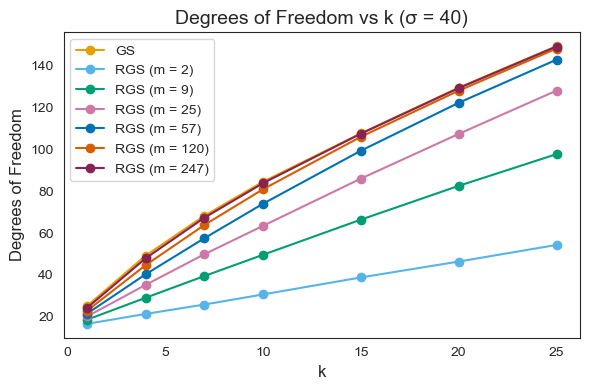

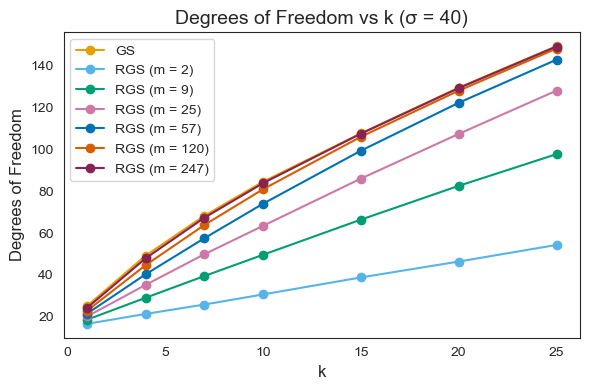

In [3]:
plot_df_vs_k("../data/simulation_results_ortho_exact_final.csv", 40, save_path="../figures/df_vs_k_sigma40_ortho_exact_final.png")

In [ ]:
plot_mse_by_variance_explained("../data/simulation_results_ortho_nonlinear_eta10.csv", save_path="../figures/mse_by_variance_explained_ortho_nonlinear_eta10.png")